# Track football players with YOLOv8 + ByteTrack 

ByteTrack is a multi object tracker that identifies and identifies the trajectory of objects with accuracy.

In this notebook we will track football players on the field from YOLOv8 predictions. 

YOLOv8 was trained on [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset from Roboflow .

Download weights here: https://drive.google.com/drive/folders/1ssaMH89UP9WGeZU_E9rQNzYxasQ6yp8t?usp=sharing


Setup

In [ ]:
%pip install ultralytics --quiet 

In [ ]:
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
%pip install cython_bbox --quiet 

In [ ]:
%pip install onemetric --quiet 

In [1]:
import sys
sys.path.append("ByteTrack")

In [2]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2

In [3]:
from pathlib import Path

path_project = Path(r"C:\Users\HP\Desktop\solution1")


## Load the video

In [4]:
def get_video_frames(video_path):
    from pathlib import Path
    video_path = Path(video_path)
    print(f"📂 Reading from: {video_path} | Exists: {video_path.exists()}")

    video = cv2.VideoCapture(str(video_path))
    if not video.isOpened():
        print("❌ Failed to open video!")
        return []

    frames = []
    while True:
        success, frame = video.read()
        if not success:
            break
        frames.append(frame)

    video.release()
    print(f"✅ Total frames extracted: {len(frames)}")
    return frames


In [5]:
from pathlib import Path

path_project = Path(r"C:\Users\HP\Desktop\solution1")
video_path = path_project / "clips" / "15sec_input_720p.mp4"


In [6]:
frames = get_video_frames(video_path)

📂 Reading from: C:\Users\HP\Desktop\solution1\clips\15sec_input_720p.mp4 | Exists: True
✅ Total frames extracted: 375


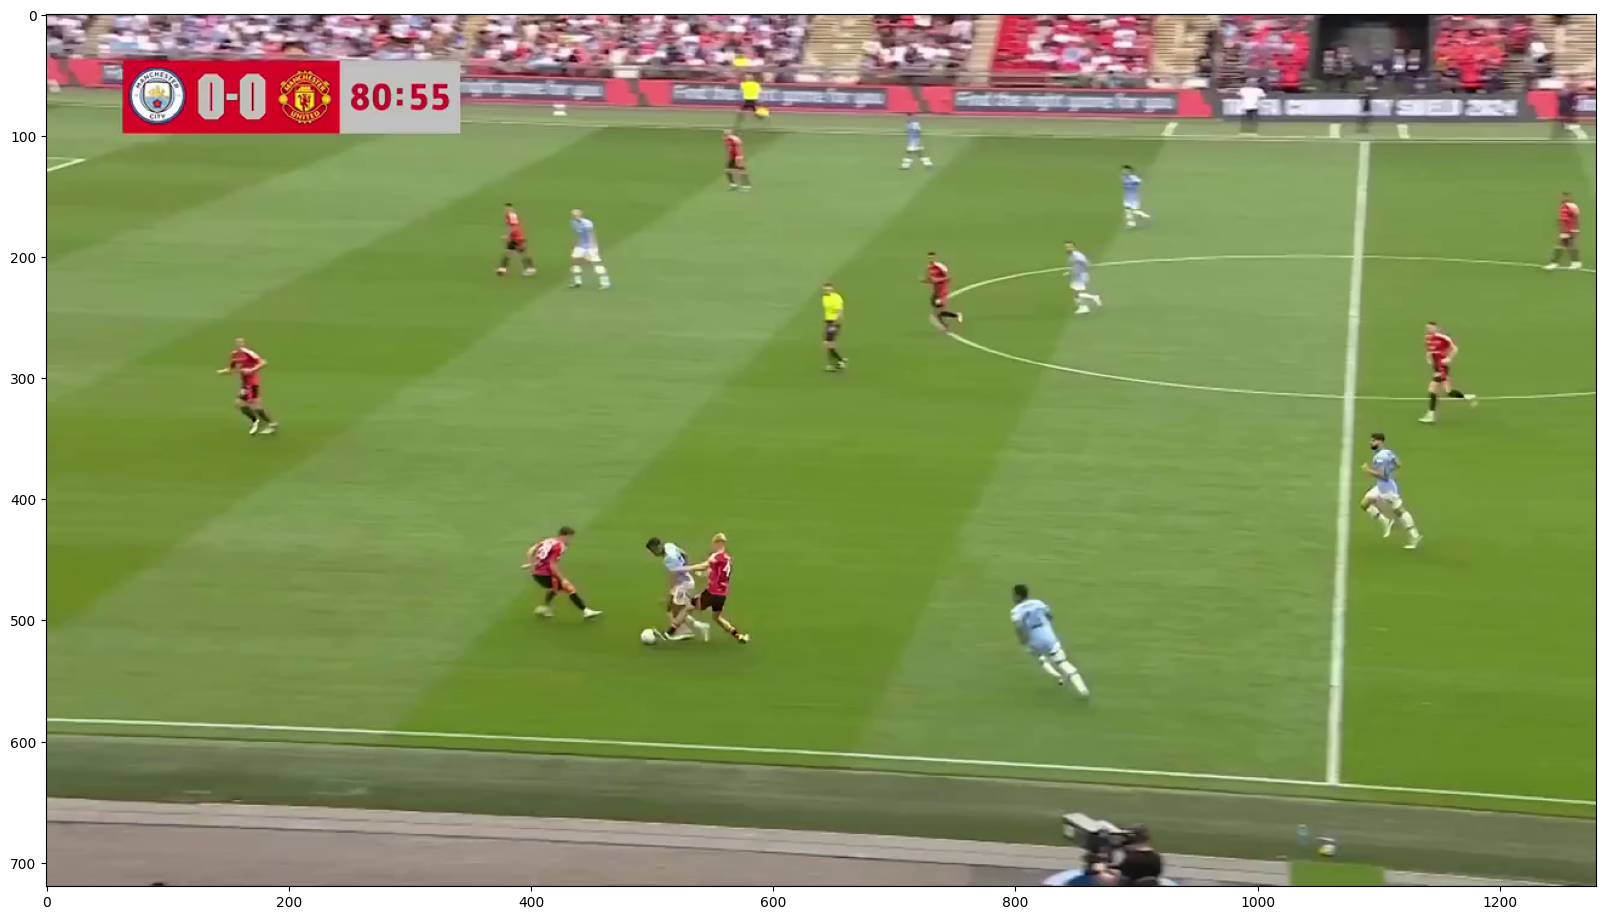

In [7]:
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.show()

## Load YOLOv8

In [8]:
from pathlib import Path

path_weights = Path(r"C:\Users\HP\Desktop\solution1\yolov8-weights\yolov8m-640-football-players.pt")


In [9]:
yolo_model = YOLO(path_weights)

ind_to_cls = {
    0: "ball",
    1 : "goalkeeper",
    2 : "player",
    3 : "referee"
}

colors = {
    "ball": (0,200,200),
    "player": (255,0,0),
    "goalkeeper":(255,0,255),
    "referee": (0,0,255),
}

Display predictions on the first frame

In [10]:
prediction = yolo_model(frames[0])


0: 384x640 1 ball, 16 players, 2 referees, 64.7ms
Speed: 3.8ms preprocess, 64.7ms inference, 102.6ms postprocess per image at shape (1, 3, 384, 640)


In [11]:
def draw_detections(image, detections, tracker_ids=None, draw_tacker_id: bool = False):
    image = image.copy()
    for i, box in enumerate(detections.boxes):
        bbox = box.xyxy.int().tolist()[0]
        cls_ind = int(box.cls.item())
        label = ind_to_cls[cls_ind]
        color = colors[label]

        cv2.rectangle(image, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)

        if draw_tacker_id and tracker_ids is not None and tracker_ids[i] != -1:
            text = f"{label} ID:{tracker_ids[i]}"
        else:
            text = label

        cv2.putText(image, text, (bbox[0], bbox[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return image

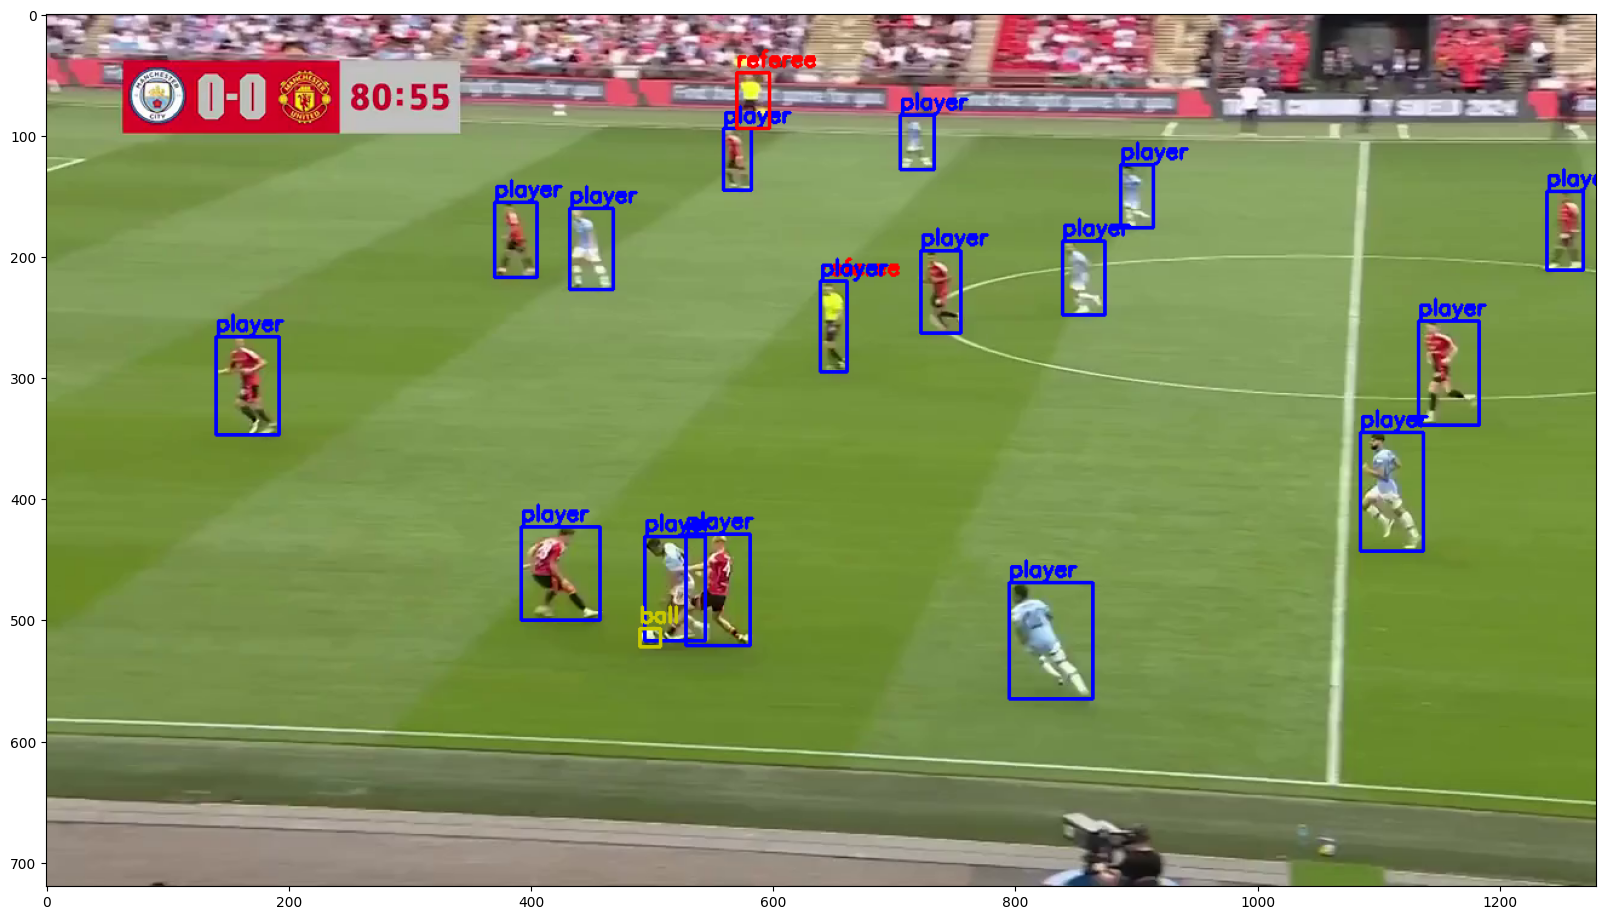

In [12]:
image = draw_detections(frames[0], prediction[0])

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()

## Create ByteTracker

ByteTrack creates trackers that are identified and attempts to find their trajectory across the frames.  
Also it expects the detection to have this format: (x1, y1, x2, y2, conf).

So we need to convert yolo detections to ByteTrack format and also identify they correspond to which tracker that is followed by ByteTrack.

In [13]:
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
  track_thresh: float = 0.25
  track_buffer: int = 30
  match_thresh: float = 0.8
  aspect_ratio_thresh: float = 3.0
  min_box_area: float = 1.0
  mot20: bool = False

In [14]:
# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs)

In [15]:
def format_predictions(yolo_detections, with_conf=True):
    dets = []
    for box, conf in zip(yolo_detections.boxes.xyxy.cpu().numpy(),
                         yolo_detections.boxes.conf.cpu().numpy()):
        if with_conf:
            dets.append([*box.tolist(), float(conf)])
        else:
            dets.append(box.tolist())
    if len(dets) == 0:
        shape = (0, 5) if with_conf else (0, 4)
        return np.zeros(shape, dtype=float)
    return np.array(dets, dtype=float)


In [16]:
def match_detections_with_tracks(detections, tracks):
    """
    Match YOLO detections with ByteTrack tracks using IoU.
    Returns a list of tracker IDs aligned with detections.boxes.
    """
    if len(detections.boxes) == 0 or len(tracks) == 0:
        return [-1] * len(detections.boxes)

    det_boxes = detections.boxes.xyxy.cpu().numpy()
    track_boxes = np.array([track.tlbr for track in tracks], dtype=float)

    ious = box_iou_batch(track_boxes, det_boxes)
    matched_indices = np.argmax(ious, axis=1)

    tracker_ids = [-1] * len(det_boxes)
    for track_idx, det_idx in enumerate(matched_indices):
        if ious[track_idx, det_idx] > 0.3:
            tracker_ids[det_idx] = int(tracks[track_idx].track_id)

    return tracker_ids

In [17]:
def get_video_writer(output_video_path, fps, width, height):
  """
  Create a video writer to save new frames after annotation
  """
  output_video_path.parent.mkdir(exist_ok=True)
  return cv2.VideoWriter(
      str(output_video_path),
      fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
      fps=fps,
      frameSize=(width, height),
      isColor=True
  )

## Track players and save to video

In [18]:
output_video_path = path_project/ ("tracking/tracked_yolov8l_640_" + video_path.stem + ".mp4")

# Get actual width and height from the first frame
first_frame = frames[0]
height, width = first_frame.shape[:2]

video_writer = get_video_writer(
    output_video_path,
    fps=30,
    width=width,
    height=height
)


In [19]:
import cv2
from pathlib import Path

# Define video path
video_path = Path(r"C:\Users\HP\Desktop\solution1\clips\15sec_input_720p.mp4")

# Read all frames from the video
def get_video_frames(video_path):
    cap = cv2.VideoCapture(str(video_path))
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

# Now define frames
frames = get_video_frames(video_path)


In [20]:
from ultralytics import YOLO
from pathlib import Path

# Load model weights
path_weights = Path(r"C:\Users\HP\Desktop\solution1\yolov8-weights\yolov8l-640-football-players.pt")
yolo_model = YOLO(path_weights)


In [21]:
import sys
sys.path.append("ByteTrack")  # Add local ByteTrack module to path

from yolox.tracker.byte_tracker import BYTETracker
from dataclasses import dataclass


from yolox.tracker.byte_tracker import BYTETracker
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

# Create tracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())


In [22]:
import cv2
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass
from yolox.tracker.byte_tracker import BYTETracker
from onemetric.cv.utils.iou import box_iou_batch

# --------------------------
# BYTETracker Configuration
# --------------------------
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

byte_tracker = BYTETracker(BYTETrackerArgs())

# --------------------------
# Format YOLOv8 Detections
# --------------------------
def format_predictions(yolo_output):
    dets = []
    for box, conf in zip(
        yolo_output.boxes.xyxy.cpu().numpy(),
        yolo_output.boxes.conf.cpu().numpy()
    ):
        dets.append([*box.tolist(), float(conf)])
    return np.array(dets, dtype=float) if len(dets) > 0 else np.zeros((0, 5), dtype=float)

# --------------------------
# Match ByteTrack tracks to YOLO detections
# --------------------------
def match_detections_with_tracks(detections, tracks):
    if len(detections.boxes) == 0 or len(tracks) == 0:
        return [-1] * len(detections.boxes)

    det_boxes = detections.boxes.xyxy.cpu().numpy()
    track_boxes = np.array([track.tlbr for track in tracks], dtype=float)

    ious = box_iou_batch(track_boxes, det_boxes)
    matched_indices = np.argmax(ious, axis=1)

    tracker_ids = [-1] * len(det_boxes)
    for track_idx, det_idx in enumerate(matched_indices):
        if ious[track_idx, det_idx] > 0.3:
            tracker_ids[det_idx] = int(tracks[track_idx].track_id)

    return tracker_ids

# --------------------------
# Draw Function (You must define colors, ind_to_cls externally)
# --------------------------
def draw_detections(image, detections, tracker_ids=None, draw_tacker_id=False):
    image = image.copy()
    for i, box in enumerate(detections.boxes):
        bbox = box.xyxy.int().tolist()[0]
        cls_ind = int(box.cls.item())
        label = ind_to_cls[cls_ind]
        color = colors[label]

        cv2.rectangle(image, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)

        if draw_tacker_id and tracker_ids and tracker_ids[i] != -1:
            text = f"{label} ID:{tracker_ids[i]}"
        else:
            text = label

        cv2.putText(image, text, (bbox[0], bbox[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return image

# --------------------------
# Main Processing Loop
# --------------------------
for frame in tqdm(frames, desc="Processing Frames"):
    # Run YOLOv8 inference
    results = yolo_model(frame, verbose=False)
    yolo_detections = results[0]

    # Format for ByteTrack
    formatted_dets = format_predictions(yolo_detections)

    # Track with ByteTrack
    tracks = byte_tracker.update(
        output_results=formatted_dets,
        img_info=frame.shape,
        img_size=frame.shape
    )

    # Match YOLO boxes with tracked IDs
    tracker_ids = match_detections_with_tracks(yolo_detections, tracks)

    # Draw and save
    annotated_frame = draw_detections(frame, yolo_detections, tracker_ids, draw_tacker_id=True)
    video_writer.write(annotated_frame)

# Finalize video
video_writer.release()
print("✅ Video processing complete.")


Processing Frames: 100%|██████████| 375/375 [00:16<00:00, 23.22it/s]

✅ Video processing complete.
